# Applicant Ranking

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_jobs = pd.read_csv('jobs.csv')
df_resume = pd.read_csv('resume_sections.csv')
df_resume.drop(columns=['INTERESTS', 'AWARDS'], inplace=True)
df_resume.fillna('', inplace=True)

In [3]:
df_jobs

,title,description,skills,education,experience
0,Senior Backend Developer,We are seeking a highly skilled Senior Backend...,"Python, Django, RESTful APIs, SQL",Bachelor in Computer Engineering,3 years of software development experience in ...
1,Full Stack Developer,We are hiring a versatile Full Stack Developer...,"HTML, CSS, JavaScript, Node.js, Express, Mongo...",Bachelor Degree in Computer Science,7 years of data analysis experience using Exce...
2,Python Backend Engineer,We have an exciting opportunity for a Python B...,"Python, Django, Flask, SQL, AWS",Masters in Computer Science,4 years of marketing experience with a focus o...
3,Backend Software Engineer,We are looking for a talented Backend Software...,"Java, Spring, Hibernate, RESTful APIs, MySQL",PhD in Computer Science,2 years of web development experience using Dj...
4,Junior Backend Developer,We are seeking a motivated Junior Backend Deve...,"Python, Django, Git, Linux, SQL",Bachelor in Computer Engineering,1 year of data analytics experience with Table...


In [4]:
df_resume.head()

,EXPERIENCE,SKILLS,EDUCATION,Filename,PROFILE,PROJECTS,CERTIFICATIONS
0,"Resume Worded, New York, NY Front End Develop...",Web Development MySQL HTML Scrum Adobe Ph...,Resume Worded University Master of Engineering...,1. Front End Developer - Resume,,,
1,"Resume Worded, New York, NY Web Developer Jan...",Critical Thinking Programming Operations Anal...,Resume Worded University Bachelor of Web Devel...,1. Web Developer - Resume,,,
2,"Resume Worded , New York, NY Jun 2018 – Presen...",● PHP ● Webpack ● Blackboard Software ● Sh...,"Resume Worded University, San Francisco, CA M...",2. Full Stack Web Developer - Resume,,,
3,RESUME WORDED & CO. (8 employee venture-backe...,,"RESUME WORDED UNIVERSITY Boston, MA Bachelor o...",3. Entry Level Web Developer Resume,,,
4,"RESUME WORDED San Francisco, CA and New York, ...",,"GROWTHSI San Francisco, CA Master of Science i...",4. Freelance Web Developer resume,,,


## Preprocessing

In [5]:
import re

def clean_description(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\+]', ' ', text)
    # Remove extra blank spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text

clean_description("I have skills in developing applications using Python3, React.js, and JavaScript.      I can use Java, express.JS!")

'i have skills in developing applications using python react js and javascript i can use java express js'

In [6]:
# Combine text from all columns to get overall resume text
df_resume['clean_resume_text'] = df_resume[['PROFILE', 'EXPERIENCE', 'PROJECTS', 'CERTIFICATIONS']].apply(lambda row: ' '.join(row), axis=1).apply(clean_description)
df_resume.head(-5)[['Filename', 'PROFILE', 'EXPERIENCE', 'PROJECTS', 'clean_resume_text']]

,Filename,PROFILE,EXPERIENCE,PROJECTS,clean_resume_text
0,1. Front End Developer - Resume,,"Resume Worded, New York, NY Front End Develop...",,resume worded new york ny front end developer ...
1,1. Web Developer - Resume,,"Resume Worded, New York, NY Web Developer Jan...",,resume worded new york ny web developer januar...
2,2. Full Stack Web Developer - Resume,,"Resume Worded , New York, NY Jun 2018 – Presen...",,resume worded new york ny jun present full sta...
3,3. Entry Level Web Developer Resume,,RESUME WORDED & CO. (8 employee venture-backe...,,resume worded co employee venture backed recru...
4,4. Freelance Web Developer resume,,"RESUME WORDED San Francisco, CA and New York, ...",,resume worded san francisco ca and new york ny...
5,freelance-web-developer2 - Template 14,,______________________________________________...,,resume worded new york ny present freelance we...
6,front-end-web-developer2 - Template 16,,______________________________________________...,,resume worded new york ny present augmented re...
7,Full Stack Web Developer - Template 10,,______________________________________________...,,full stack web developer november present resu...


In [7]:
df_resume.drop(columns=['PROFILE', 'CERTIFICATIONS'], inplace=True)

# Choose target job

In [8]:
target_job = df_jobs.loc[1]

Preprocess job description  
This adds the title, and skills to the description.  
Then cleans it.

In [9]:
def preprocess_job(target_job):
    title, description, skills = (
        target_job['title'],
        target_job['description'],
        target_job['skills'],
    )    # Clean description
    if skills:
        description = skills.replace(',', '') + ' ' + description
    if title:
        description = f'{title} {description}'
    description = clean_description(description)
    # print('Cleaned job description:', description)
    return description

## Tfidf
For comparing job-description and resume-description

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [11]:

def get_description_score(target_job):
    # Initialize the TfidfVectorizer
    # min_df=3 means ignore terms that appear in less than 3 document
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)

    # fit_transform the vectorizers and create tfidf matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform([preprocess_job(target_job)] + df_resume['clean_resume_text'].values.tolist())
    
    # Calculate cosine similarity between the job description and resumes
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    df_resume['description_score'] = cosine_similarities

In [12]:
get_description_score(target_job)

In [13]:
df_resume[['Filename', 'clean_resume_text', 'description_score']]

,Filename,clean_resume_text,description_score
0,1. Front End Developer - Resume,resume worded new york ny front end developer ...,0.113592
1,1. Web Developer - Resume,resume worded new york ny web developer januar...,0.135216
2,2. Full Stack Web Developer - Resume,resume worded new york ny jun present full sta...,0.234872
3,3. Entry Level Web Developer Resume,resume worded co employee venture backed recru...,0.064003
4,4. Freelance Web Developer resume,resume worded san francisco ca and new york ny...,0.146137
5,freelance-web-developer2 - Template 14,resume worded new york ny present freelance we...,0.105760
6,front-end-web-developer2 - Template 16,resume worded new york ny present augmented re...,0.201379
7,Full Stack Web Developer - Template 10,full stack web developer november present resu...,0.223503
8,junior-web-developer - Template 10,junior web developer november present resume w...,0.085847
9,php-developer - Template 18,resume worded london united kingdom education ...,0.150306


## 1. Skills

#### How it works?
For each applicant, a binary vector is created where each element represents the presence (1) or absence (0) of a specific skill from the target job in the applicant's skills.

**Convert job description skills and applicant skills into binary feature vectors**

In [14]:
target_job['skills'].split(', ')

['HTML',
 'CSS',
 'JavaScript',
 'Node.js',
 'Express',
 'MongoDB',
 'React',
 'AWS',
 'Bootstrap']

In [15]:
df_resume['SKILLS']

0      Web Development  MySQL  HTML  Scrum  Adobe Ph...
1      Critical Thinking Programming Operations Anal...
2     ●  PHP ●  Webpack ●  Blackboard Software ●  Sh...
3                                                      
4                                                      
5     ______________________________________________...
6     ______________________________________________...
7     ______________________________ Technical Skill...
8     ______________________________ Technical Skill...
9     __________________________ Hard Skills: •  Obj...
10    ______________________________________________...
11    ______________________________________________...
12    __________________________ Languages: •  JavaS...
Name: SKILLS, dtype: object

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

# Helper function to check if a skill is present in the resume description
def skill_present(skill, description):
    # Use regular expression pattern matching to match the whole word
    pattern = r"\b" + re.escape(skill) + r"\b"
    return bool(re.search(pattern, description, re.IGNORECASE))


def vectorize_skills(df_resume_texts):
    # The 'skills' column has string values. Each string has skills sepearated by comma. So convert them to array of skills.
    target_job_skills = target_job['skills'].lower().split(', ')
    # Initialize the MultiLabelBinarizer
    mlb = MultiLabelBinarizer(classes=target_job_skills)

    # Create a list of skills for each applicant's project
    applicant_skills_vector = df_resume_texts.apply(lambda x: [skill for skill in target_job_skills if skill_present(skill, x)])

    # Use the MultiLabelBinarizer to transform the 'skills' column into binary vectors
    applicant_binary_vectors = mlb.fit_transform(applicant_skills_vector)

    return applicant_binary_vectors.tolist()


In [17]:
df_resume['skills_vector'] = vectorize_skills(df_resume['SKILLS'])
df_resume[['Filename', 'SKILLS', 'skills_vector']]

,Filename,SKILLS,skills_vector
0,1. Front End Developer - Resume,Web Development MySQL HTML Scrum Adobe Ph...,"[1, 0, 1, 0, 0, 0, 0, 0, 0]"
1,1. Web Developer - Resume,Critical Thinking Programming Operations Anal...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
2,2. Full Stack Web Developer - Resume,● PHP ● Webpack ● Blackboard Software ● Sh...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,3. Entry Level Web Developer Resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4. Freelance Web Developer resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,freelance-web-developer2 - Template 14,______________________________________________...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,front-end-web-developer2 - Template 16,______________________________________________...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]"
7,Full Stack Web Developer - Template 10,______________________________ Technical Skill...,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
8,junior-web-developer - Template 10,______________________________ Technical Skill...,"[0, 0, 0, 0, 0, 0, 1, 0, 1]"
9,php-developer - Template 18,__________________________ Hard Skills: • Obj...,"[0, 0, 1, 1, 0, 0, 0, 0, 0]"


In [18]:
target_job['skills_vector'] = np.ones(len(target_job['skills'].split(', ')))
target_job.skills, target_job.skills_vector

('HTML, CSS, JavaScript, Node.js, Express, MongoDB, React, AWS, Bootstrap',
 array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [19]:
def get_skills_score():
    target_vector = np.array(target_job['skills_vector']).reshape(1, -1)
    applicant_vector = np.array(df_resume['skills_vector'].tolist())
    similarity_scores = cosine_similarity(target_vector, applicant_vector)
    df_resume['skills_score'] = similarity_scores.flatten()

# target_vector is created from target_job['skills_vector']. It's reshaped to a 2D array with reshape(1, -1) because cosine_similarity expects a 2D array.
# applicant_vectors is created by converting df_resume['skills_vector'] to a NumPy array using tolist(). This is done because cosine_similarity expects a 2D array.

In [20]:
get_skills_score()

In [21]:
df_resume[['Filename', 'SKILLS', 'skills_vector', 'skills_score']]

,Filename,SKILLS,skills_vector,skills_score
0,1. Front End Developer - Resume,Web Development MySQL HTML Scrum Adobe Ph...,"[1, 0, 1, 0, 0, 0, 0, 0, 0]",0.471405
1,1. Web Developer - Resume,Critical Thinking Programming Operations Anal...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]",0.471405
2,2. Full Stack Web Developer - Resume,● PHP ● Webpack ● Blackboard Software ● Sh...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",0.333333
3,3. Entry Level Web Developer Resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000
4,4. Freelance Web Developer resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000
5,freelance-web-developer2 - Template 14,______________________________________________...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000
6,front-end-web-developer2 - Template 16,______________________________________________...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",0.333333
7,Full Stack Web Developer - Template 10,______________________________ Technical Skill...,"[0, 0, 0, 0, 0, 0, 0, 0, 1]",0.333333
8,junior-web-developer - Template 10,______________________________ Technical Skill...,"[0, 0, 0, 0, 0, 0, 1, 0, 1]",0.471405
9,php-developer - Template 18,__________________________ Hard Skills: • Obj...,"[0, 0, 1, 1, 0, 0, 0, 0, 0]",0.471405


## 2. Projects

#### How it works?
***It checks if the applicant has made at least one project using the required skills or not.***

1. The job description skills are converted into a binary feature vector, where each element represents the presence or absence of a skill in the job description.

2. A helper function skill_present is defined to check if a skill is present in the project description using regular expression pattern matching to match the whole word.

3. The vectorize_project function takes the applicant projects and job skills as input and converts the project descriptions into binary feature vectors. For each applicant, it iterates over the skills and checks if any of the skills are present in the project descriptions using the skill_present function.

4. The cosine similarity is calculated between the job_skills_vector and each applicant's project vector using the cosine_similarity function. The similarity score represents how closely the applicant's projects match the job description skills.

Testing the vectorization of projects description

In [22]:
projects = [
    'i have done project in (python, django rest).', 
    ' javaScript, node.js, reactjs',
    ' py. django-rest, r(java), NodeJS. '
]
projects = pd.Series(projects)
app_vec = projects.apply(lambda x: [skill for skill in ['Python', 'Django', 'Django rest', 'java', 'js', 'react', 'nodejs'] if skill_present(skill, x)])
print(app_vec)

0    [Python, Django, Django rest]
1                             [js]
2           [Django, java, nodejs]
dtype: object


In [23]:
# Convert applicant projects into binary feature vectors
df_resume['projects_vector'] = vectorize_skills(df_resume['PROJECTS'])

In [24]:
def get_projects_score():
    target_vector = np.array(target_job['skills_vector']).reshape(1, -1)
    applicant_vector = np.array(df_resume['projects_vector'].tolist())
    similarity_scores = cosine_similarity(target_vector, applicant_vector)
    df_resume['projects_score'] = similarity_scores.flatten()

# target_vector is created from target_job['skills_vector']. It's reshaped to a 2D array with reshape(1, -1) because cosine_similarity expects a 2D array.
# applicant_vectors is created by converting df_resume['projects_vector'] to a NumPy array using tolist(). This is done because cosine_similarity expects a 2D array.

In [25]:
get_projects_score()

In [26]:
df_resume[['Filename', 'PROJECTS', 'projects_vector', 'projects_score']]

,Filename,PROJECTS,projects_vector,projects_score
0,1. Front End Developer - Resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
1,1. Web Developer - Resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
2,2. Full Stack Web Developer - Resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
3,3. Entry Level Web Developer Resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
4,4. Freelance Web Developer resume,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
5,freelance-web-developer2 - Template 14,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
6,front-end-web-developer2 - Template 16,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
7,Full Stack Web Developer - Template 10,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
8,junior-web-developer - Template 10,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
9,php-developer - Template 18,,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0


## 3. Education

### Identify Degree and Major in Education

Our system uses spacy library to extract information (degree and major) from Education. We prepared a dictionary that has all education degrees and majors related to computer engineering field. We fed that dictionary to the Spacy rule-based EntityRuler in order to detect and recognize entities in our job description.

In [27]:
import spacy
from spacy import displacy

In [28]:
def match_degrees_by_spacy(education_text, nlp):
    doc = nlp(education_text)
    degree_levels = []
    for ent in doc.ents:
        labels_parts = ent.label_.split('|')
        if labels_parts[0] == 'DEGREE':
            # print((ent.text, ent.label_))
            if labels_parts[1] not in degree_levels:
                degree_levels.append(labels_parts[1])
    return degree_levels


def match_majors_by_spacy(education_text, nlp):
    doc = nlp(education_text)
    acceptable_majors = []
    for ent in doc.ents:
        labels_parts = ent.label_.split('|')
        if labels_parts[0] == 'MAJOR':
            if labels_parts[2].replace('-', ' ') not in acceptable_majors:
                acceptable_majors.append(labels_parts[2].replace('-', ' '))
            if labels_parts[2].replace('-', ' ') not in acceptable_majors:
                acceptable_majors.append(labels_parts[2].replace('-', ' '))
    return acceptable_majors

In [29]:
df_resume['EDUCATION'][5], target_job['education']

('_______________________________________________________________________________________________________________ Resume Worded Academy,  New York, NY 2011 Certiﬁed WordPress Developer ',
 'Bachelor Degree in Computer Science')

In [30]:
# Function to extract degree level and field of study from education
def extract_education_info():
    # Initialize the NLP pipeline and entity ruler
    nlp = spacy.load("en_core_web_sm")
    ruler = nlp.add_pipe("entity_ruler", before='ner')

    # Load the degree and major patterns
    ruler.from_disk('degrees_majors.jsonl')

    # Initialize lists to store the results
    resume_degrees = []
    resume_majors = []

    # Extract degree and major for each resume
    for education_text in df_resume['EDUCATION']:
        degrees = match_degrees_by_spacy(education_text, nlp)
        majors = match_majors_by_spacy(education_text, nlp)
        resume_degrees.append(degrees)
        resume_majors.append(majors)
    
    # Extract degree and major for the target job
    job_degree = match_degrees_by_spacy(target_job['education'], nlp)
    job_major = match_majors_by_spacy(target_job['education'], nlp)

    df_resume['education_degree'], df_resume['education_major'], target_job['education_degree'], target_job['education_major'] = resume_degrees, resume_majors, job_degree, job_major
    
    return resume_degrees, resume_majors, job_degree, job_major

#### How it works?
It considers two factors seperately: degree and field of study.

1. Degree
- Values are assigned to different degree levels. Eg: Bachelor=1, Master=2, PhD=3
- A lower degree score indicates better similarity, with 0 being the best possible score.
- Normalize the score to be between 0 and 1 and adjust such that a higher score indicates better similarity.

2. Field of Study
- measures the text similarity between the applicant's field of study and the job's required field of study.
3. Combining Degree and Field Scores
The degree score is weighted by 0.7, and the field score is weighted by 0.3.


Education Degree Score

In [31]:
# Define a mapping for degree levels
degree_mapping = {
    'BACHELOR': 1,
    'MASTER': 2,
    'PHD': 3,
}

def get_education_degree_score(resume_degrees, job_degree):
    # Apply the mapping to the list of degrees
    numerical_degrees = [[degree_mapping.get(degree, 0) for degree in degrees] for degrees in resume_degrees]
    # Get the highest degree for each resume
    applicant_degrees = [max(degrees) if degrees else 0 for degrees in numerical_degrees]

    # Convert the job degree to numerical form
    numerical_job_degree = [degree_mapping.get(degree, 0) for degree in job_degree]
    # Get the minimum degree required for the job
    min_degree_required = min(numerical_job_degree)

    degree_scores = []
    for applicant_degree in applicant_degrees:
        degree_score = 0
        
        if applicant_degree >= min_degree_required:
            degree_score = 0
        else:
            degree_score = min_degree_required-applicant_degree

        # smaller degree score means greater similarity (0 means exact)
        # the max_degree_score may be 2 (eg: phd vs bachelor)
        max_degree_score = 2 
        # By dividing (max_score - degree_score) by max_score, you normalize the score to be between 0 and 1, where a higher score indicates better similarity.
        degree_score = (max_degree_score - degree_score) / max_degree_score

        degree_scores.append(degree_score)

    return degree_scores
        

Education Major (Field of Study) Score

In [32]:
from difflib import SequenceMatcher

# Function to calculate text similarity using SequenceMatcher
def calculate_education_major_similarity(str1, str2):
    return SequenceMatcher(None, str1.lower(), str2.lower()).ratio()

def get_education_major_score(resume_majors, job_major):
    field_scores = []

    for resume_major in resume_majors:
        # Convert resume_major array to string separated by ' '
        applicant_major = ' '.join(resume_major)
        field_score = 0
        similarities = [calculate_education_major_similarity(applicant_major, required_major) for required_major in job_major]
        # Find max similarity score
        if similarities:
            field_score = max(similarities)
        field_scores.append(field_score)

    return field_scores   

Education Score by combining degree and majors score

In [33]:
def get_education_score():
    resume_degrees, resume_majors, job_degree, job_major = extract_education_info()

    degree_scores = get_education_degree_score(resume_degrees, job_degree)
    field_scores = get_education_major_score(resume_majors, job_major)

    # Set weights for degree and field_of_study
    degree_weight = 0.7
    field_weight = 0.3

    combined_scores = [degree_weight * degree_score + field_weight * field_score for degree_score, field_score in zip(degree_scores, field_scores)]

    df_resume['education_score'] = combined_scores


In [34]:
get_education_score()

In [35]:
target_job[['education', 'education_degree', 'education_major']]

education           Bachelor Degree in Computer Science
education_degree                             [BACHELOR]
education_major                      [computer science]
Name: 1, dtype: object

In [36]:
df_resume[['Filename', 'EDUCATION', 'education_degree', 'education_major', 'education_score']]

,Filename,EDUCATION,education_degree,education_major,education_score
0,1. Front End Developer - Resume,Resume Worded University Master of Engineering...,"[BACHELOR, MASTER]",[],0.700000
1,1. Web Developer - Resume,Resume Worded University Bachelor of Web Devel...,[BACHELOR],[web development],0.777419
2,2. Full Stack Web Developer - Resume,"Resume Worded University, San Francisco, CA M...","[BACHELOR, MASTER]",[computer engineering],0.900000
3,3. Entry Level Web Developer Resume,"RESUME WORDED UNIVERSITY Boston, MA Bachelor o...",[BACHELOR],"[computer science, mathematics, software engin...",0.807865
4,4. Freelance Web Developer resume,"GROWTHSI San Francisco, CA Master of Science i...","[MASTER, BACHELOR]","[computer science, mathematics, programming]",0.871429
5,freelance-web-developer2 - Template 14,______________________________________________...,[],[],0.350000
6,front-end-web-developer2 - Template 16,______________________________________________...,[BACHELOR],[computer science],1.000000
7,Full Stack Web Developer - Template 10,______________________________ Resume Worded U...,[BACHELOR],[computer science],1.000000
8,junior-web-developer - Template 10,______________________________ Resume Worded U...,"[BACHELOR, MASTER]",[computer science],1.000000
9,php-developer - Template 18,__________________________ University of New Y...,[BACHELOR],[],0.700000


## 4. Experience

- Extracts the 'X years' part from the target job experience.
- Calculates similarity scores for each applicant's experience, taking the ratio of their 'X years' to the target job's 'X years'. 
- The score is limited it to a maximum of 1.0 to avoid giving excessive credit to applicants with more experience than needed.

In [37]:
df_resume['EXPERIENCE'][7]

"______________________________________________________________________ Full Stack Web Developer November 2015 – Present Resume Worded, New York, NY ● Created a web application that allowed 75K users to search for nearby restaurants based on their location with 89% accuracy. ● Worked with a team of 27 developers that created an e-commerce website using PHP, MySQL, and JavaScript within 3 months. ● Developed a responsive email template in HTML5 and CSS3 that increased the clickthrough rate by 78%, an improvement from previous years. ● Participated in code reviews of 300 developers’ ensuring that all code complied 100% with coding standards & best practices. Front End Developer February 2013 – October 2015 Growthsi, San Francisco, CA ● Developed front-end code using HTML, CSS, JavaScript, jQuery to create a responsive web application that works across 29 devices, including desktops and tablets. ● Optimized 29 web pages for speed and performance by eliminating unnecessary scripts/styles a

Minimum years of experience for target job

In [38]:
import re

# Function to extract years of exp from job description
def extract_min_experience(text):
    # Define the regular expression patterns
    pattern_months = r'(\d+)(?=\s*month)'
    pattern_years = r'(\d+)(?=\s*year)'
    
    # Use search to get the first match
    match_years = re.search(pattern_years, text)
    match_months = re.search(pattern_months, text)
    
    # If a match was found, convert it to an integer and return
    if match_years:
        return int(match_years.group())
    elif match_months:
        return int(match_months.group()) / 12  # Convert months to years
    
    # If no match was found, return None
    return 0

# Convert job experience to 'X years' information
extract_min_experience(target_job['experience'])

7

Create EntityRuler to extract dates from experience information

In [39]:
import spacy

def create_nlp_for_experience():
    nlp = spacy.load("en_core_web_sm")

    VALID_MONTH_NAMES = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec", "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]


    # Most of the date patterns are detected by default DATE entity
    # Define the pattern for '05/2015 - 06/2017' and '10/2020 - Present'.
    patterns = [
        # 05/2015 - 06/2017
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"SHAPE": "dd/dddd"}]},

        # 10/2020 - Present
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"LOWER": "present"}]},
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"LOWER": "current"}]},

        # Jan 2020 - current, March 2018 - Present
        {"label": "DATE", "pattern": [{"LOWER": {"in": VALID_MONTH_NAMES}}, {"TEXT": {"REGEX": "^\d{4}$"}}, {"TEXT": "-"}, {"LOWER": {"in": ["current", "present"]}}]},

        # Jun 2016 - Sep 2016
        {"label": "DATE", "pattern": [{"LOWER": {"in": VALID_MONTH_NAMES}},
        {"TEXT": {"REGEX": "^\d{4}$"}}, {"TEXT": "-"}, {"LOWER": {"in": VALID_MONTH_NAMES}}, {"TEXT": {"REGEX": "^\d{4}$"}}]},

        # 2020 - current
        {"label": "DATE", "pattern": [{"SHAPE": "dddd"}, {"TEXT": "-"}, {"LOWER": {"in": ["current", "present"]}}]},
        ]

    ruler = nlp.add_pipe("entity_ruler", before='ner')
    # Add the pattern to the ruler
    ruler.add_patterns(patterns)

    return nlp

Calculate years of experience from applicant's resume

In [40]:
from dateutil import parser
from dateutil.relativedelta import relativedelta
from datetime import datetime

def extract_years(dates):
    years = 0
    for date in dates:
        # Check if the date is in the "start - end" format
        if '-' not in date:
            continue
        
        try:
            # Split the date range into start and end dates
            start_date, end_date = date.split('-')
            
            # Replace 'Present' or 'current' with today's date
            if 'present' in end_date.lower() or 'current' in end_date.lower():
                end_date = datetime.today().strftime('%m/%Y')
            
            # Parse the dates
            start_date = parser.parse(start_date)
            end_date = parser.parse(end_date)
            
            # Calculate the difference in years (considering months)
            diff = relativedelta(end_date, start_date)
            years += round(diff.years + diff.months / 12, 2)
        
        except ValueError as e:
            print(f"Error parsing dates: {e}. Skipping this entry.")
        
    return years

In [41]:
def get_experience_score():
    target_job_experience = extract_min_experience(target_job['experience'])
    
    nlp = create_nlp_for_experience()

    # First, replace En-dash '–' with Hyphen '-' before NER. e.g. Jun 2018 – Present
    df_resume['EXPERIENCE'] = df_resume['EXPERIENCE'].str.replace('–', '-')

    experience_date_vectors = []
    # Calculate similarity scores for each applicant
    applicant_scores = []
    for applicant_experience in df_resume['EXPERIENCE']:
        doc = nlp(applicant_experience)

        # Extract the dates that are in the 'start - end' format
        extracted_dates = [ent.text for ent in doc.ents if ent.label_ == 'DATE' and '-' in ent.text]
        experience_date_vectors.append(extracted_dates)

        applicant_years = extract_years(extracted_dates)

        if target_job_experience == 0: # no experience requireed
            similarity_score = 1.0
        else:  
            similarity_score = min(applicant_years / target_job_experience, 1.0)
        applicant_scores.append(similarity_score)

    df_resume['experience_dates'] = experience_date_vectors
    df_resume['experience_score'] = applicant_scores

In [42]:
get_experience_score()

Error parsing dates: Unknown string format: 2 weeks. Skipping this entry.
Error parsing dates: Unknown string format: day. Skipping this entry.


In [43]:
target_job['experience']

'7 years of data analysis experience using Excel and SQL.'

In [44]:
df_resume[['Filename', 'EXPERIENCE', 'experience_dates', 'experience_score']]

,Filename,EXPERIENCE,experience_dates,experience_score
0,1. Front End Developer - Resume,"Resume Worded, New York, NY Front End Develop...","[January 2020 - Present, July 2016 - January 2...",1.000000
1,1. Web Developer - Resume,"Resume Worded, New York, NY Web Developer Jan...","[January 2020 - Present, July 2016 - January 2...",1.000000
2,2. Full Stack Web Developer - Resume,"Resume Worded , New York, NY Jun 2018 - Presen...","[Jun 2018 - Present, Jan 2015 - May 2018, May ...",1.000000
3,3. Entry Level Web Developer Resume,RESUME WORDED & CO. (8 employee venture-backe...,"[Jun 2017 - Sep 2017, Jun 2016 - Sep 2016, 3-day]",0.071429
4,4. Freelance Web Developer resume,"RESUME WORDED San Francisco, CA and New York, ...","[2017-Present, 2013-2017, 2012-2013]",1.000000
5,freelance-web-developer2 - Template 14,______________________________________________...,"[2015 - Present, 2013 - 2015, 2011 - 2013]",1.000000
6,front-end-web-developer2 - Template 16,______________________________________________...,"[09/2015 - Present, 10/2012 - 08/2015, 07/2010...",1.000000
7,Full Stack Web Developer - Template 10,______________________________________________...,"[November 2015 - Present, February 2013 - Octo...",1.000000
8,junior-web-developer - Template 10,______________________________________________...,"[November 2015 - Present, February 2013 - Octo...",1.000000
9,php-developer - Template 18,______________________________________________...,"[01/2022 - Present, 10/2019 - 12/2021, 11/2018...",1.000000


#### Finally, so far

In [45]:
df_resume.head()

,EXPERIENCE,SKILLS,EDUCATION,Filename,PROJECTS,clean_resume_text,description_score,skills_vector,skills_score,projects_vector,projects_score,education_degree,education_major,education_score,experience_dates,experience_score
0,"Resume Worded, New York, NY Front End Develop...",Web Development MySQL HTML Scrum Adobe Ph...,Resume Worded University Master of Engineering...,1. Front End Developer - Resume,,resume worded new york ny front end developer ...,0.113592,"[1, 0, 1, 0, 0, 0, 0, 0, 0]",0.471405,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[BACHELOR, MASTER]",[],0.700000,"[January 2020 - Present, July 2016 - January 2...",1.000000
1,"Resume Worded, New York, NY Web Developer Jan...",Critical Thinking Programming Operations Anal...,Resume Worded University Bachelor of Web Devel...,1. Web Developer - Resume,,resume worded new york ny web developer januar...,0.135216,"[1, 1, 0, 0, 0, 0, 0, 0, 0]",0.471405,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[BACHELOR],[web development],0.777419,"[January 2020 - Present, July 2016 - January 2...",1.000000
2,"Resume Worded , New York, NY Jun 2018 - Presen...",● PHP ● Webpack ● Blackboard Software ● Sh...,"Resume Worded University, San Francisco, CA M...",2. Full Stack Web Developer - Resume,,resume worded new york ny jun present full sta...,0.234872,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",0.333333,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[BACHELOR, MASTER]",[computer engineering],0.900000,"[Jun 2018 - Present, Jan 2015 - May 2018, May ...",1.000000
3,RESUME WORDED & CO. (8 employee venture-backe...,,"RESUME WORDED UNIVERSITY Boston, MA Bachelor o...",3. Entry Level Web Developer Resume,,resume worded co employee venture backed recru...,0.064003,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[BACHELOR],"[computer science, mathematics, software engin...",0.807865,"[Jun 2017 - Sep 2017, Jun 2016 - Sep 2016, 3-day]",0.071429
4,"RESUME WORDED San Francisco, CA and New York, ...",,"GROWTHSI San Francisco, CA Master of Science i...",4. Freelance Web Developer resume,,resume worded san francisco ca and new york ny...,0.146137,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[MASTER, BACHELOR]","[computer science, mathematics, programming]",0.871429,"[2017-Present, 2013-2017, 2012-2013]",1.000000


- `calculate_total_score()` computes weighted total scores for resumes by combining attributes such as description, skills, projects, education, and experience. 
- Then, it sorts resumes based on these scores.

In [46]:
def calculate_total_score():
    description_weight = 0.15
    skills_weight = 0.2
    projects_weight = 0.1
    education_weight = 0.2
    experience_weight = 0.35

    df_resume['total_score'] = df_resume['description_score']*description_weight + df_resume['skills_score']*skills_weight + df_resume['projects_score']*projects_weight + df_resume['education_score']*education_weight + df_resume['experience_score']*experience_weight

    # Sort the DataFrame based on total_score in descending order
    df_resume_rankings_sorted = df_resume.sort_values(by='total_score', ascending=False)

    display(df_resume_rankings_sorted)

In [47]:
calculate_total_score()

,EXPERIENCE,SKILLS,EDUCATION,Filename,PROJECTS,clean_resume_text,description_score,skills_vector,skills_score,projects_vector,projects_score,education_degree,education_major,education_score,experience_dates,experience_score,total_score
12,______________________________________________...,__________________________ Languages: • JavaS...,__________________________ University of New Y...,web-developer2 - Template 18,,resume worded london united kingdom education ...,0.154687,"[0, 0, 1, 1, 0, 0, 1, 0, 1]",0.666667,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[BACHELOR],[computer programming],0.883333,"[08/2021 - Present, 10/2019 - 07/2021, 11/2018...",1.000000,0.683203
8,______________________________________________...,______________________________ Technical Skill...,______________________________ Resume Worded U...,junior-web-developer - Template 10,,junior web developer november present resume w...,0.085847,"[0, 0, 0, 0, 0, 0, 1, 0, 1]",0.471405,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[BACHELOR, MASTER]",[computer science],1.000000,"[November 2015 - Present, February 2013 - Octo...",1.000000,0.657158
7,______________________________________________...,______________________________ Technical Skill...,______________________________ Resume Worded U...,Full Stack Web Developer - Template 10,,full stack web developer november present resu...,0.223503,"[0, 0, 0, 0, 0, 0, 0, 0, 1]",0.333333,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[BACHELOR],[computer science],1.000000,"[November 2015 - Present, February 2013 - Octo...",1.000000,0.650192
6,______________________________________________...,______________________________________________...,______________________________________________...,front-end-web-developer2 - Template 16,,resume worded new york ny present augmented re...,0.201379,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",0.333333,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[BACHELOR],[computer science],1.000000,"[09/2015 - Present, 10/2012 - 08/2015, 07/2010...",1.000000,0.646874
2,"Resume Worded , New York, NY Jun 2018 - Presen...",● PHP ● Webpack ● Blackboard Software ● Sh...,"Resume Worded University, San Francisco, CA M...",2. Full Stack Web Developer - Resume,,resume worded new york ny jun present full sta...,0.234872,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",0.333333,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[BACHELOR, MASTER]",[computer engineering],0.900000,"[Jun 2018 - Present, Jan 2015 - May 2018, May ...",1.000000,0.631898
10,______________________________________________...,______________________________________________...,______________________________________________...,php-developer - Template 14,,resume worded new york ny present php develope...,0.185911,"[1, 1, 0, 0, 0, 0, 0, 0, 0]",0.471405,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[BACHELOR],[information technology],0.794737,[2015 - Present],1.000000,0.631115
1,"Resume Worded, New York, NY Web Developer Jan...",Critical Thinking Programming Operations Anal...,Resume Worded University Bachelor of Web Devel...,1. Web Developer - Resume,,resume worded new york ny web developer januar...,0.135216,"[1, 1, 0, 0, 0, 0, 0, 0, 0]",0.471405,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[BACHELOR],[web development],0.777419,"[January 2020 - Present, July 2016 - January 2...",1.000000,0.620047
9,______________________________________________...,__________________________ Hard Skills: • Obj...,__________________________ University of New Y...,php-developer - Template 18,,resume worded london united kingdom education ...,0.150306,"[0, 0, 1, 1, 0, 0, 0, 0, 0]",0.471405,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[BACHELOR],[],0.700000,"[01/2022 - Present, 10/2019 - 12/2021, 11/2018...",1.000000,0.606827
0,"Resume Worded, New York, NY Front End Develop...",Web Development MySQL HTML Scrum Adobe Ph...,Resume Worded University Master of Engineering...,1. Front End Developer - Resume,,resume worded new york ny front end developer ...,0.113592,"[1, 0, 1, 0, 0, 0, 0, 0, 0]",0.471405,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[BACHELOR, MASTER]",[],0.700000,"[January 2020 - Present

## Visualization

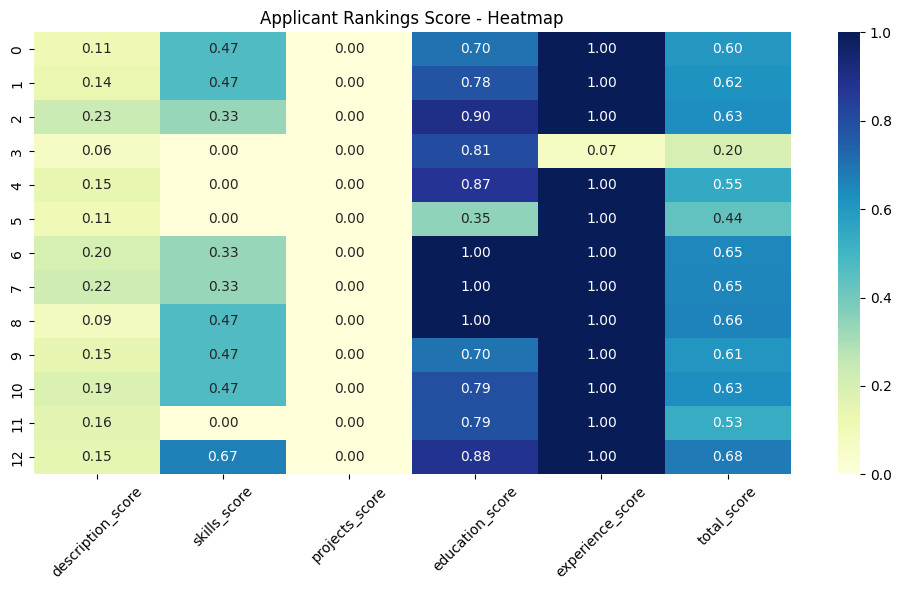

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_heatmap(df):
    columns_to_visualize = ['description_score', 'skills_score', 'projects_score', 'education_score', 'experience_score', 'total_score']
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[columns_to_visualize], cmap='YlGnBu', annot=True, fmt=".2f")
    plt.title('Applicant Rankings Score - Heatmap')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_heatmap(df_resume)

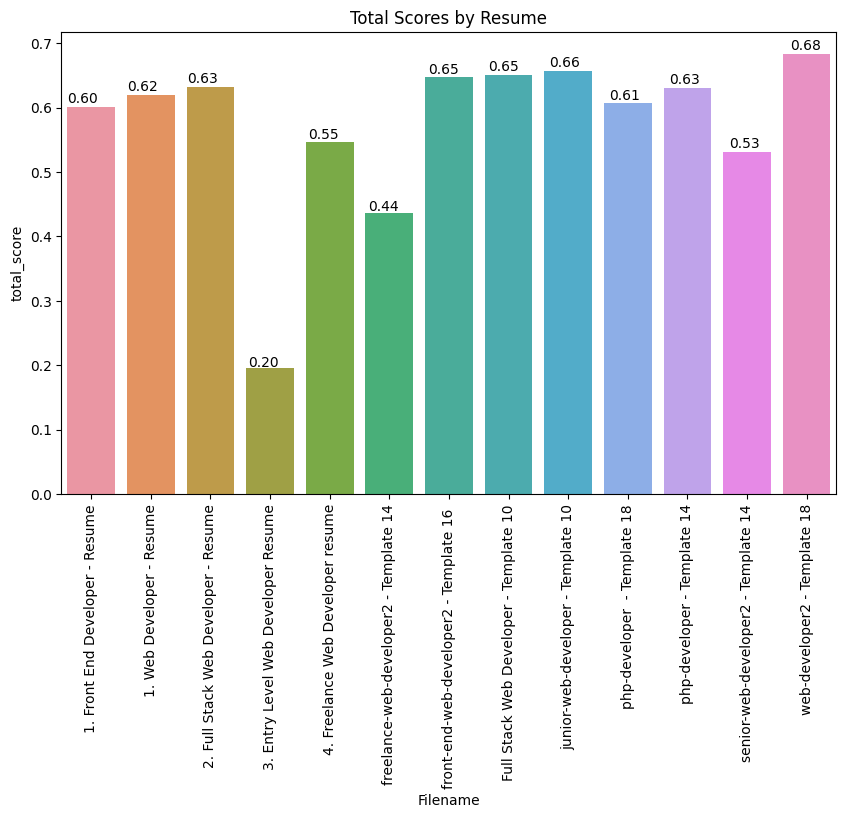

In [49]:
def visualize_total_scores(df_resume):
    # Bar chart for total scores using seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Filename", y="total_score", data=df_resume)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x()*1.01, p.get_height()*1.01))
    plt.xticks(rotation=90)
    plt.title("Total Scores by Resume")
    plt.show()

visualize_total_scores(df_resume)